# ITU BLG453E (computer vision) - HW2
---
**Student:** Emil Huseynov  

**Student_ID:** 150210906

**Subject:** BLG453E

**Assignment:** HW2  

**Date:** 18.11.2024

**Due_date:** 05.12.2024

---

In [19]:
#For Q1,Q2,Q3
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

#For Q4
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

#Q1 (30 pts) Segment Image with Otsu’s Algorithm


### Required functions for Q1:


In [2]:
def add_gaussian_noise(image, mean=0, sigma=0.1, clip=True, clip_range=(0, 255)):
    """
    Adds Gaussian noise to an image.

    Parameters:
    - image (numpy.ndarray): The input image.
    - mean (float): Mean of the Gaussian noise.
    - sigma (float): Standard deviation of the Gaussian noise.
    - clip (bool): Whether to clip the output values to a specified range.
    - clip_range (tuple): The range (min, max) to clip the values to.

    Returns:
    - numpy.ndarray: The noisy image.
    """
    noise = np.random.normal(mean, sigma, image.shape)
    noisy_image = image + noise
    if clip:
        noisy_image = np.clip(noisy_image, clip_range[0], clip_range[1])
    return noisy_image

def otsu_threshold(image):
    # Flatten the image to a 1D array
    pixels = image.flatten()
    total_pixels = pixels.size

    # Compute histogram
    histogram = np.zeros(256)
    unique, counts = np.unique(pixels, return_counts=True)
    for u, c in zip(unique, counts):
        histogram[u] = c

    # Probability of each intensity level
    pdf = histogram / total_pixels

    # Cumulative sum of the probability and mean
    cdf = np.cumsum(pdf)
    cumulative_mean = np.cumsum(pdf * np.arange(256))

    # Total mean intensity of the image
    global_mean = cumulative_mean[-1]

    # Initialize variables
    sigma_b_squared = np.zeros(256)

    # Compute between-class variance for all thresholds
    for T in range(256):
        w0 = cdf[T]
        w1 = 1 - w0

        if w0 == 0 or w1 == 0:
            sigma_b_squared[T] = 0
            continue

        mu0 = cumulative_mean[T] / w0
        mu1 = (global_mean - cumulative_mean[T]) / w1

        sigma_b_squared[T] = w0 * w1 * (mu0 - mu1) ** 2

    # Find the optimal threshold
    optimal_threshold = np.argmax(sigma_b_squared)

    # Segment the image using the optimal threshold
    segmented_image = (image >= optimal_threshold).astype(int)

    return optimal_threshold, segmented_image




##Q1.1 (10 pts) Gaussian Noise

###Code:

(-0.5, 5.5, 5.5, -0.5)

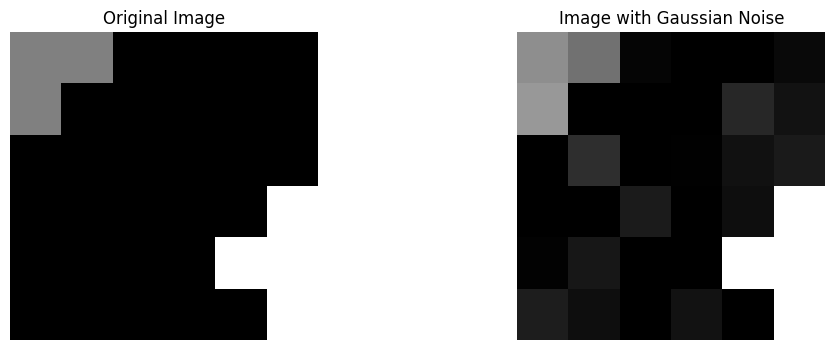

In [20]:
# Create the original image
x = np.zeros((6, 6), dtype=float)
x[0, 0:2] = 1
x[1, 0] = 1
x[3:, 5] = 2
x[4, 4] = 2

# Add Gaussian noise to the image using the function
sigma_noise = 0.2  # Standard deviation of the noise
x_noisy = add_gaussian_noise(x, mean=0, sigma=sigma_noise, clip=True, clip_range=(0, 2))

# Display the original and noisy images
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray', vmin=0, vmax=2)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_noisy, cmap='gray', vmin=0, vmax=2)
plt.title('Image with Gaussian Noise')
plt.axis('off')



---
##Q1.2 (20 pts) Otsu’s Algorithm

###Code:

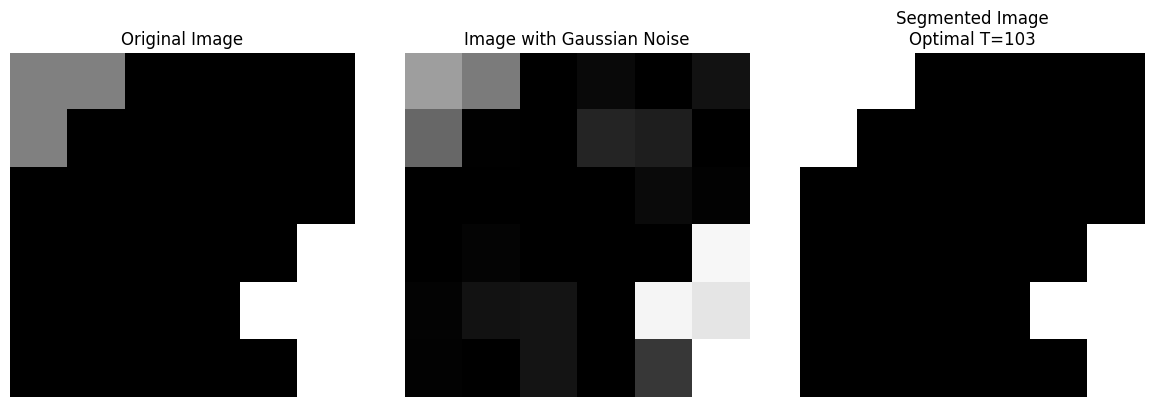

Optimal Threshold (T*): 103


In [4]:
# Display the original and noisy images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(x, cmap='gray', vmin=0, vmax=2)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(x_noisy, cmap='gray', vmin=0, vmax=2)
plt.title('Image with Gaussian Noise')
plt.axis('off')

# Prepare the noisy image for Otsu's algorithm
# Scale the noisy image to 8-bit grayscale values (0-255)
x_noisy_scaled = (x_noisy / x_noisy.max()) * 255
x_noisy_scaled = x_noisy_scaled.astype(np.uint8)

# Apply Otsu's thresholding
optimal_threshold, segmented_image = otsu_threshold(x_noisy_scaled)

# Display the segmented image
plt.subplot(1, 3, 3)
plt.imshow(segmented_image, cmap='gray')
plt.title(f'Segmented Image\nOptimal T={optimal_threshold}')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Optimal Threshold (T*): {optimal_threshold}")




---



---




#Q2 (20 pts) Image Noise Addition and Removal?

*   Add salt-and-pepper noise and impulse noise to Lenna.png image, seperately.
*   Apply an appropriate filter to remove the salt-and-pepper noise and im- pulse noise from the Lenna.png.


###Required functions are given below:


In [5]:
def add_salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    """
    Adds salt and pepper noise to an image.

    :param image: Input image (numpy array)
    :param salt_prob: Probability of adding salt noise
    :param pepper_prob: Probability of adding pepper noise
    :return: Noisy image
    """
    noisy_image = image.copy()
    # Add salt noise
    num_salt = int(salt_prob * image.size)
    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape[:2]]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    # Add pepper noise
    num_pepper = int(pepper_prob * image.size)
    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape[:2]]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

def add_impulse_noise(image, noise_prob=0.1):
    """
    Adds impulse noise (random value noise) to an image.

    :param image: Input image (numpy array)
    :param noise_prob: Probability of a pixel being replaced with a random value
    :return: Noisy image
    """
    noisy_image = image.copy()
    num_noisy_pixels = int(noise_prob * image.size)
    coords = [np.random.randint(0, i - 1, num_noisy_pixels) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1]] = np.random.randint(0, 256, num_noisy_pixels)
    return noisy_image

def median_filter(image, kernel_size=3):
    """
    Applies a median filter to remove salt-and-pepper noise.

    :param image: Noisy image (numpy array)
    :param kernel_size: Kernel size for the median filter
    :return: Denoised image
    """
    return cv2.medianBlur(image, kernel_size)

##Q2.1.Salt and pepper noise example and its median filtered version is below:

###Code:

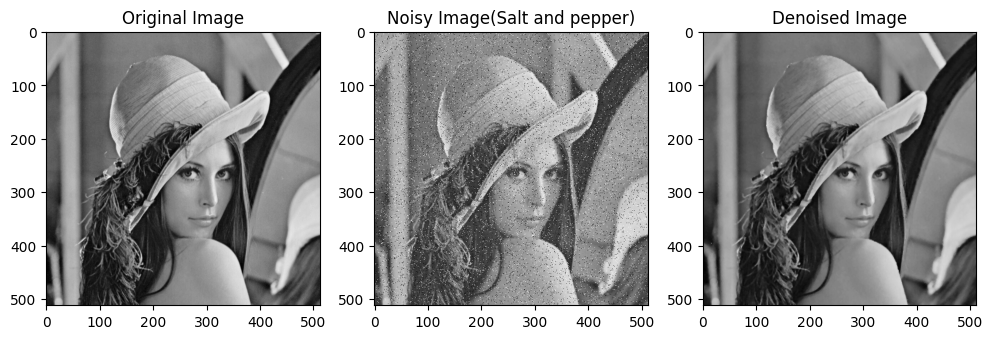

In [6]:
    # Read the PNG image
    image = cv2.imread("Lenna.png", cv2.IMREAD_GRAYSCALE)

    # Add salt-and-pepper noise
    noisy_image = add_salt_and_pepper_noise(image, 0.03, 0.03)

    # Denoise using median filtering
    denoised_image = median_filter(noisy_image)

    # Display the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1), plt.imshow(image, cmap='gray'), plt.title("Original Image")
    plt.subplot(1, 3, 2), plt.imshow(noisy_image, cmap='gray'), plt.title("Noisy Image(Salt and pepper)")
    plt.subplot(1, 3, 3), plt.imshow(denoised_image, cmap='gray'), plt.title("Denoised Image")
    plt.show()

##Q2.2.Impulse noise example and its median filtered version is below:

###Code:

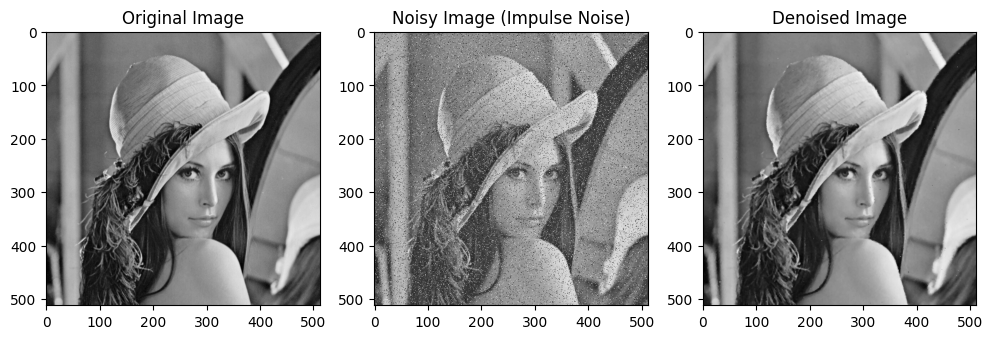

In [7]:
    # Read the PNG image
    image = cv2.imread("Lenna.png", cv2.IMREAD_GRAYSCALE)

    # Add impulse noise
    noisy_image = add_impulse_noise(image, 0.15)

    # Denoise using median filtering
    denoised_image = median_filter(noisy_image)

    # Display the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1), plt.imshow(image, cmap='gray'), plt.title("Original Image")
    plt.subplot(1, 3, 2), plt.imshow(noisy_image, cmap='gray'), plt.title("Noisy Image (Impulse Noise)")
    plt.subplot(1, 3, 3), plt.imshow(denoised_image, cmap='gray'), plt.title("Denoised Image")
    plt.show()



---



---


#Q3 (35 pts) How can read the book cover?

###The code below shows us how we can find corners and apply perspective transformation to the image

####Code:

Ordered corner points: [[ 112.  263.]
 [ 499.   32.]
 [ 471. 1665.]
 [  75. 1366.]]


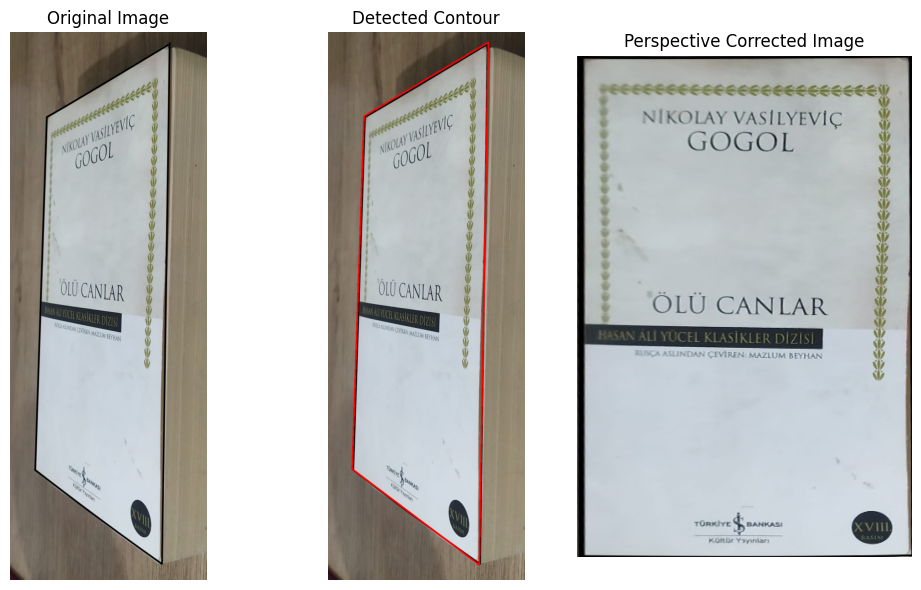

In [21]:
# Step 1: Load the Image
image_path = "gogol.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization

# Step 2: Preprocess the Image
# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply GaussianBlur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Use Canny edge detection
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Step 3: Detect Contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter for the largest rectangular contour
book_contour = None
for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) == 4:  # Look for quadrilaterals
        book_contour = approx
        break

# Check if a contour was found and draw it on the image
if book_contour is not None:
    detected_image = image_rgb.copy()
    cv2.drawContours(detected_image, [book_contour], -1, (255, 0, 0), 3)

    # Step 4: Order the corner points (Top-left, Top-right, Bottom-right, Bottom-left)
    points = book_contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")
    s = points.sum(axis=1)
    rect[0] = points[np.argmin(s)]  # Top-left
    rect[2] = points[np.argmax(s)]  # Bottom-right
    diff = np.diff(points, axis=1)
    rect[1] = points[np.argmin(diff)]  # Top-right
    rect[3] = points[np.argmax(diff)]  # Bottom-left

    print("Ordered corner points:", rect)

    # Step 5: Define destination points
    width = 400  # Desired width
    height = 600  # Desired height
    destination_points = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")

    # Step 6: Compute perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(rect, destination_points)

    # Apply perspective warp
    warped_image = cv2.warpPerspective(image_rgb, matrix, (width, height))


# Plot all intermediate and final results together for better visualization

fig, axes = plt.subplots(1, 3, figsize=(10, 6))
axes = axes.ravel()

# Original image
axes[0].imshow(image_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Detected contour
if book_contour is not None:
    axes[1].imshow(detected_image)
    axes[1].set_title("Detected Contour")
else:
    axes[1].imshow(image_rgb)
    axes[1].set_title("No Contour Detected")
axes[1].axis("off")

# Perspective corrected image
if book_contour is not None:
    axes[2].imshow(warped_image)
    axes[2].set_title("Perspective Corrected Image")
else:
    axes[2].imshow(image_rgb)
    axes[2].set_title("No Perspective Correction")
axes[2].axis("off")

plt.tight_layout()
plt.show()



---



---

#Q4 (25 pts) Understanding and Implementing Generative Adver- sarial Networks (GANs)

####Code:

In [9]:
# Hyperparameters
batch_size = 128
image_size = 32
channels_img = 3  # CIFAR-10 images are RGB
z_dim = 100       # Size of the noise vector (input to Generator)
num_epochs = 25
learning_rate = 0.0002

In [22]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and DataLoader
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*channels_img, [0.5]*channels_img)  # Normalize images to [-1, 1]
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

Files already downloaded and verified


###Generator and Discriminator is given below`

####Code:

In [23]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),  # Output: (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),    # Output: (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),    # Output: (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, channels_img, 4, 2, 1, bias=False),  # Output: (3, 32, 32)
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, channels_img):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels_img, 128, 4, 2, 1, bias=False),    # Output: (128, 16, 16)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),             # Output: (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),             # Output: (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),               # Output: (1, 1, 1)
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)


###Initializing the Models and Defining the Loss Function and Optimizers

####Code:

In [24]:
# Initialize models
netG = Generator(z_dim, channels_img).to(device)
netD = Discriminator(channels_img).to(device)

# Weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

netG.apply(weights_init)
netD.apply(weights_init)

# Loss function and optimizers
criterion = nn.BCELoss()  # Binary Cross Entropy Loss

fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)  # For generating consistent images

optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(0.5, 0.999))

###Training loop

####Code:

In [13]:
# Training Loop
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # (1) Update D network
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)

        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Generate fake images
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(0.)

        output = netD(fake_images.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update G network
        netG.zero_grad()
        label.fill_(1.)

        output = netD(fake_images)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        # Output training stats
        if i % 100 == 0:
            print(
                f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\t'
                f'Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\t'
                f'D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}'
            )

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

    # Save generated images for visualization
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

Starting Training Loop...
[0/25][0/391]	Loss_D: 1.3860	Loss_G: 0.7018	D(x): 0.5030	D(G(z)): 0.5028/0.4957
[0/25][100/391]	Loss_D: 0.0461	Loss_G: 4.0797	D(x): 0.9799	D(G(z)): 0.0254/0.0170
[0/25][200/391]	Loss_D: 0.0748	Loss_G: 4.9476	D(x): 0.9477	D(G(z)): 0.0190/0.0078
[0/25][300/391]	Loss_D: 0.3547	Loss_G: 3.6015	D(x): 0.8044	D(G(z)): 0.0785/0.0354
[1/25][0/391]	Loss_D: 0.3353	Loss_G: 4.5805	D(x): 0.8875	D(G(z)): 0.1732/0.0130
[1/25][100/391]	Loss_D: 0.8223	Loss_G: 1.3044	D(x): 0.7487	D(G(z)): 0.2920/0.3626
[1/25][200/391]	Loss_D: 0.4178	Loss_G: 5.5798	D(x): 0.6988	D(G(z)): 0.0048/0.0070
[1/25][300/391]	Loss_D: 0.4971	Loss_G: 5.5525	D(x): 0.9378	D(G(z)): 0.3224/0.0063
[2/25][0/391]	Loss_D: 0.5172	Loss_G: 2.4418	D(x): 0.6737	D(G(z)): 0.0657/0.1145
[2/25][100/391]	Loss_D: 0.2341	Loss_G: 3.6456	D(x): 0.8712	D(G(z)): 0.0799/0.0329
[2/25][200/391]	Loss_D: 0.4633	Loss_G: 4.4759	D(x): 0.9141	D(G(z)): 0.2879/0.0153
[2/25][300/391]	Loss_D: 0.4691	Loss_G: 3.3435	D(x): 0.8294	D(G(z)): 0.2160/0.0

###Plotting

####Code:

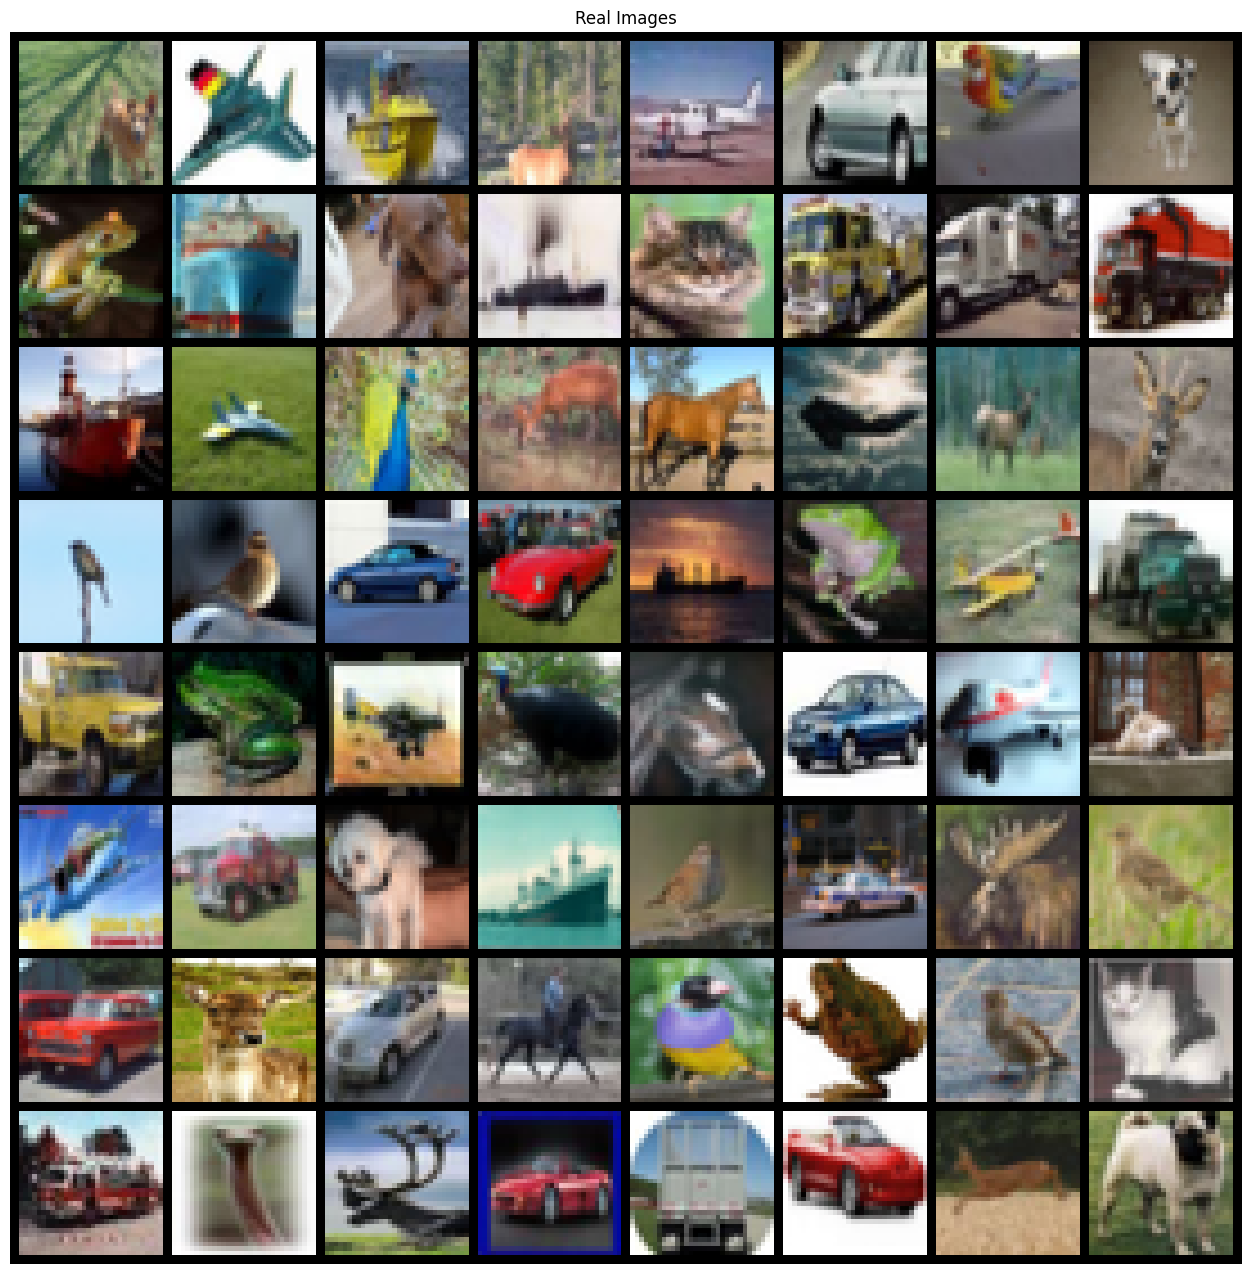

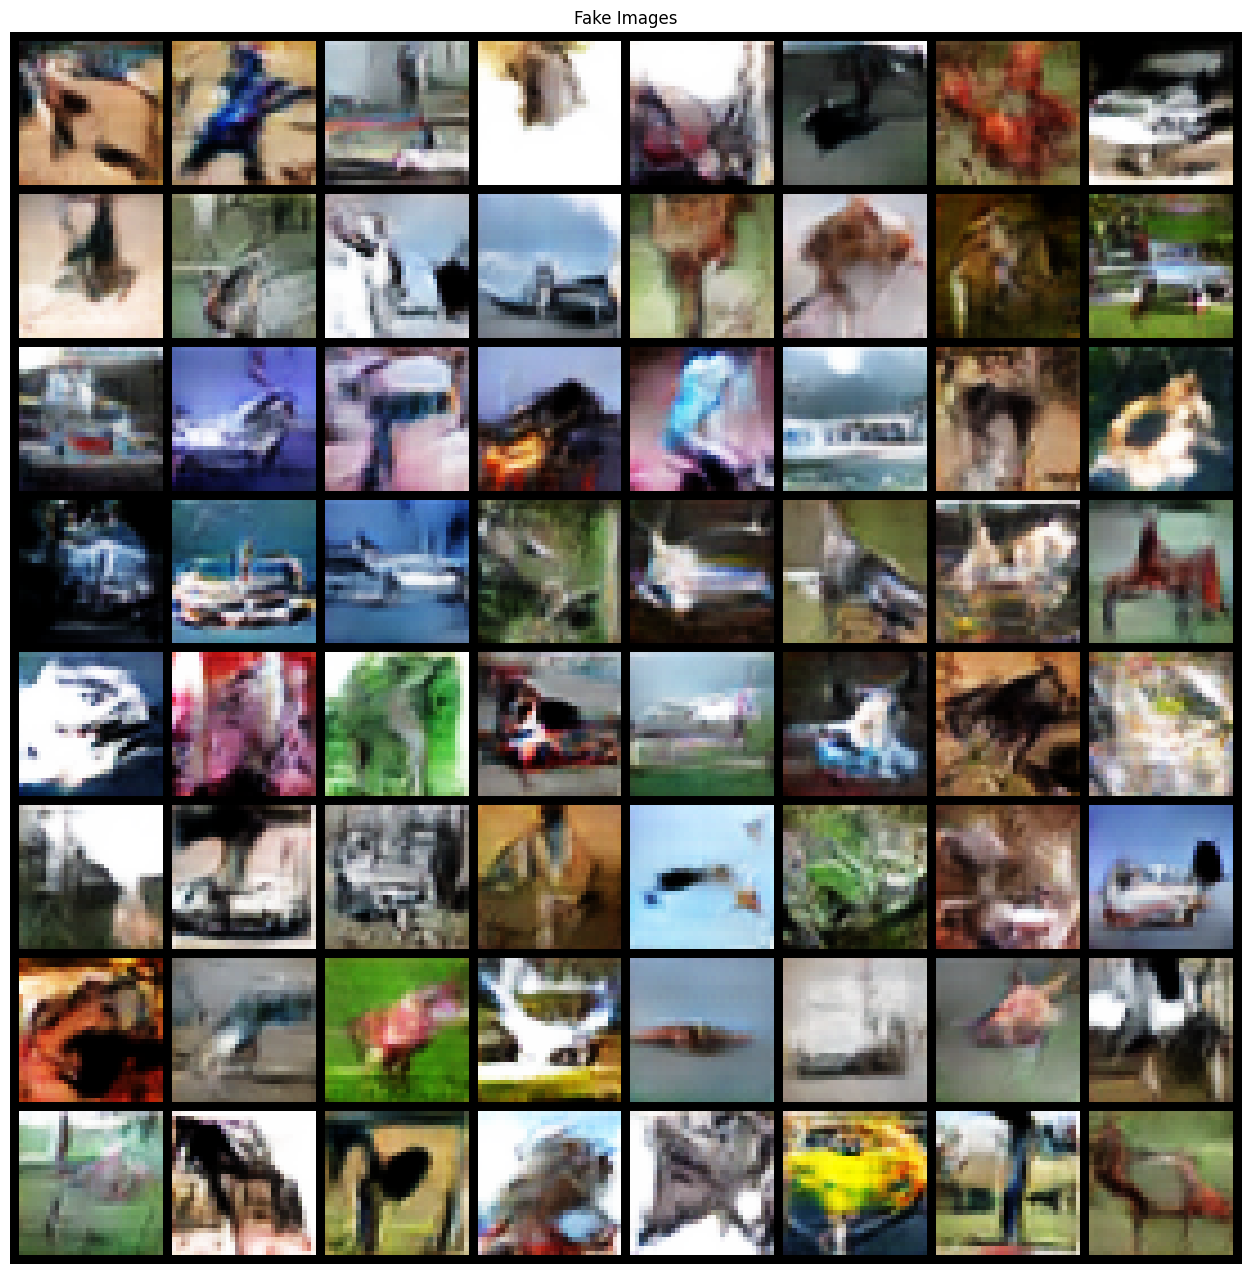

In [18]:
# Function to show images
def show_images(images, title):
    plt.figure(figsize=(48,16))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(images, (1,2,0)))
    plt.show()

# Plot the real images
real_batch = next(iter(dataloader))
real_images = torchvision.utils.make_grid(real_batch[0][:64], padding=2, normalize=True)
show_images(real_images.cpu(), "Real Images")

# Plot the fake images from the last epoch
fake_images = img_list[-1]
show_images(fake_images, "Fake Images")